In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def gaussian_pyramid(image, levels=4):
    """
    Build a Gaussian pyramid for an image.
    
    Parameters:
    - image: Input image (grayscale or color)
    - levels: Number of levels in the pyramid
    
    Returns:
    - A list containing the Gaussian pyramid levels
    """
    # Make a copy of the original image
    img = image.copy()
    
    # Initialize the pyramid with the original image
    gaussian = [img]
    
    # Generate pyramid levels
    for i in range(levels-1):
        # Apply Gaussian blur
        img = cv2.pyrDown(img)
        gaussian.append(img)
        
    return gaussian

def laplacian_pyramid(gaussian_pyramid):
    """
    Build a Laplacian pyramid from a Gaussian pyramid.
    
    Parameters:
    - gaussian_pyramid: A list of images forming a Gaussian pyramid
    
    Returns:
    - A list containing the Laplacian pyramid levels
    """
    levels = len(gaussian_pyramid)
    laplacian = []
    
    # Process all levels except the last one
    for i in range(levels-1):
        # Get the current and next Gaussian pyramid levels
        current_level = gaussian_pyramid[i]
        
        # Expand the next level to match the size of the current level
        next_level_up = cv2.pyrUp(gaussian_pyramid[i+1])
        
        # If sizes don't match exactly, resize to match current_level
        if next_level_up.shape != current_level.shape:
            next_level_up = cv2.resize(next_level_up, (current_level.shape[1], current_level.shape[0]))
        
        # Calculate the Laplacian as the difference
        laplacian_level = cv2.subtract(current_level, next_level_up)
        laplacian.append(laplacian_level)
    
    # The last level of the Laplacian pyramid is the same as the smallest level of the Gaussian pyramid
    laplacian.append(gaussian_pyramid[-1])
    
    return laplacian

def reconstruct_from_laplacian(laplacian_pyramid):
    """
    Reconstruct an image from its Laplacian pyramid.
    
    Parameters:
    - laplacian_pyramid: A list of images forming a Laplacian pyramid
    
    Returns:
    - The reconstructed image
    """
    # Start with the smallest level
    reconstructed = laplacian_pyramid[-1]
    
    # Iteratively add and expand
    for i in range(len(laplacian_pyramid)-2, -1, -1):
        # Expand current reconstruction
        reconstructed = cv2.pyrUp(reconstructed)
        
        # If sizes don't match exactly, resize to match the laplacian level
        current_laplacian = laplacian_pyramid[i]
        if reconstructed.shape != current_laplacian.shape:
            reconstructed = cv2.resize(reconstructed, (current_laplacian.shape[1], current_laplacian.shape[0]))
        
        # Add the laplacian level
        reconstructed = cv2.add(reconstructed, current_laplacian)
        
    return reconstructed


def display_pyramid(pyramid, title, normalize_laplacian=False):
    """Display all levels of a pyramid."""
    n_levels = len(pyramid)
    plt.figure(figsize=(15, 4))
    
    for i in range(n_levels):
        img = pyramid[i].copy()
        
        # For Laplacian pyramid, normalize for better visualization
        if normalize_laplacian and i < n_levels-1:
            # Convert to float for normalization
            img = img.astype(np.float32)
            # Add 128 to shift negative values to the visible range
            if len(img.shape) == 3:  # Color image
                for c in range(3):  # Process each channel
                    img[:,:,c] = img[:,:,c] + 128
            else:  # Grayscale
                img = img + 128
            # Clip to valid range
            img = np.clip(img, 0, 255).astype(np.uint8)
        
        # If the image is not grayscale, convert from BGR to RGB for display
        if len(img.shape) == 3 and img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
        plt.subplot(1, n_levels, i+1)
        plt.title(f"{title} Level {i}\n{img.shape[1]}×{img.shape[0]}")
        plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


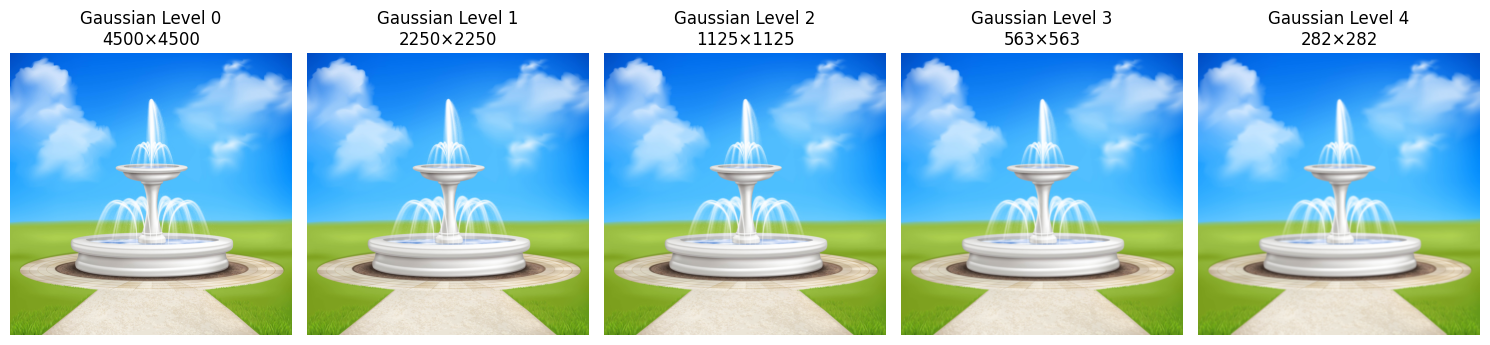

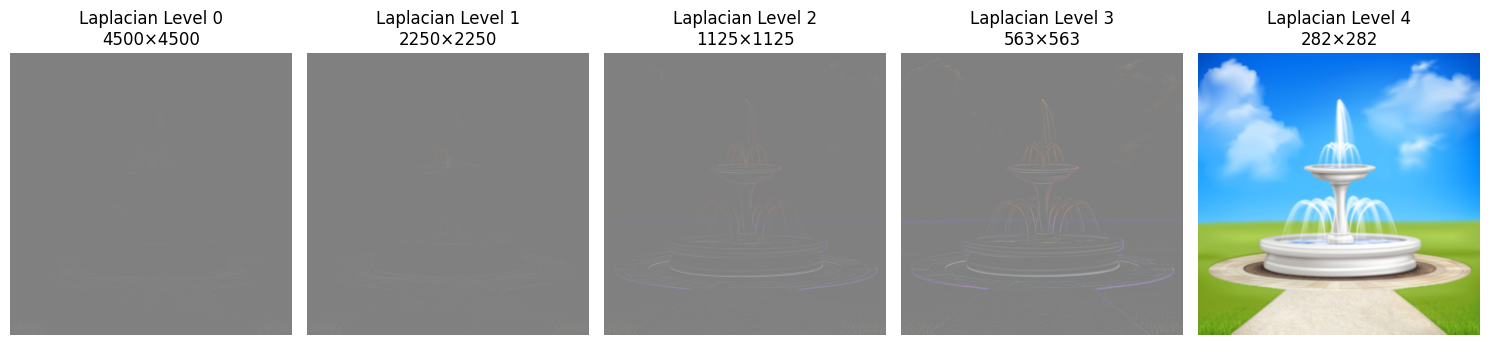

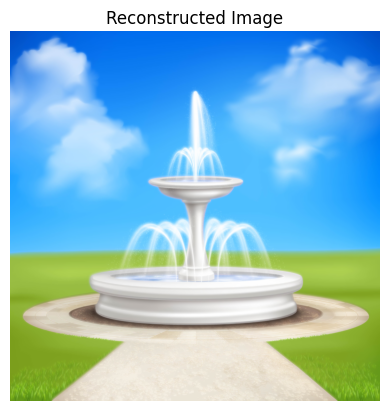

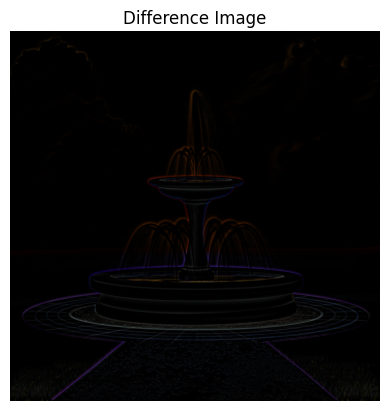

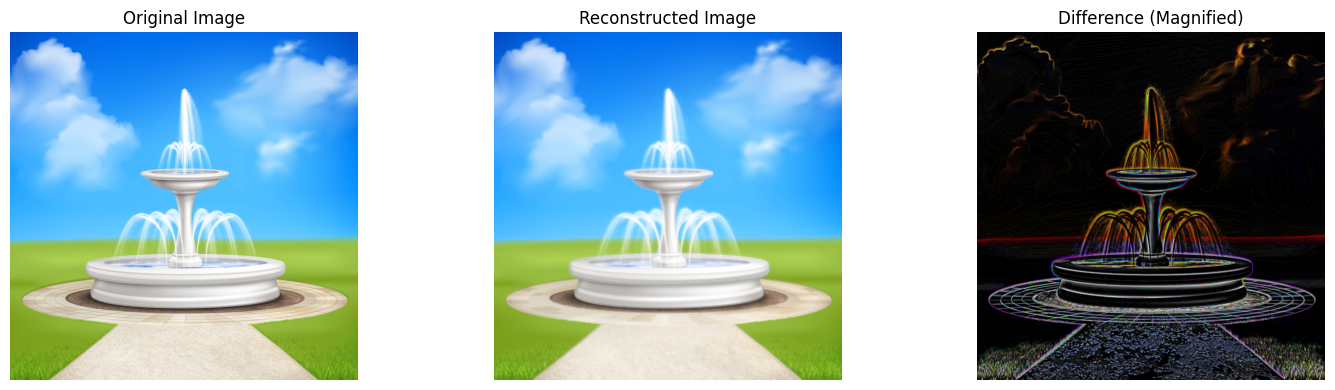

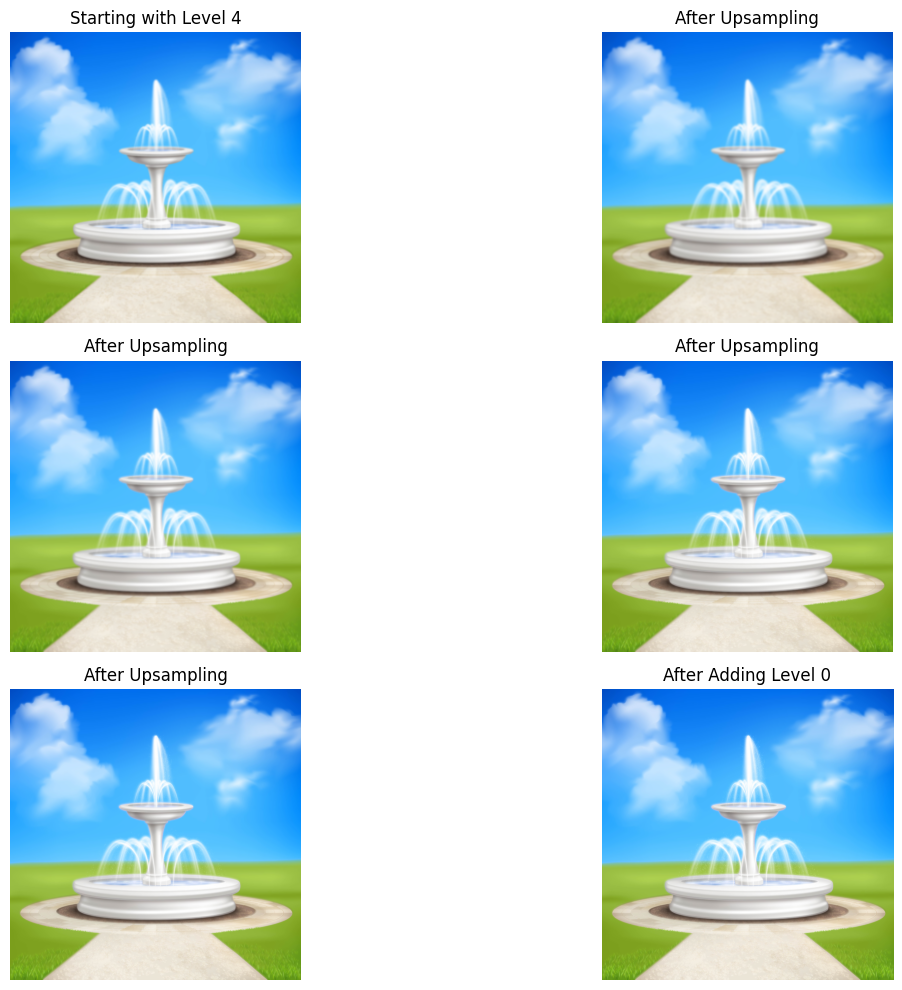

In [32]:
def demonstrate_pyramid_reconstruction(img_path):
    """Demonstrate the process of pyramid construction and reconstruction."""
    # Create a sample image with various features
    img = cv2.imread(img_path)
    
    # Number of pyramid levels
    levels = 5
    
    # Create the Gaussian pyramid
    g_pyr = gaussian_pyramid(img, levels=levels)
    display_pyramid(g_pyr, "Gaussian")
    
    # Create the Laplacian pyramid from the Gaussian pyramid
    l_pyr = laplacian_pyramid(g_pyr)
    display_pyramid(l_pyr, "Laplacian", normalize_laplacian=True)
    
    
    # Reconstruct the image from the Laplacian pyramid
    reconstructed = reconstruct_from_laplacian(l_pyr)
    diff = cv2.absdiff(img, reconstructed)
    # diff = np.minimum(diff * 10, 255).astype(np.uint8)


    plt.imshow(cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB))
    plt.title("Reconstructed Image")
    plt.axis('off')
    plt.show()

    plt.imshow(cv2.cvtColor(diff, cv2.COLOR_BGR2RGB))
    plt.title("Difference Image")
    plt.axis('off')
    plt.show()



    # Show reconstruction process step by step
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Reconstructed Image")
    plt.imshow(cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    # Calculate and display difference
    diff = cv2.absdiff(img, reconstructed)
    plt.subplot(1, 3, 3)
    plt.title("Difference (Magnified)")
    # Multiply difference by 10 to make it visible
    diff = np.minimum(diff * 10, 255).astype(np.uint8)
    plt.imshow(cv2.cvtColor(diff, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Show a progressive reconstruction (adding one level at a time)
    plt.figure(figsize=(15, 10))
    current = l_pyr[-1].copy()  # Start with the smallest level
    
    plt.subplot(3, 2, 1)
    plt.title(f"Starting with Level {levels-1}")
    plt.imshow(cv2.cvtColor(current, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    
    for i in range(levels-2, -1, -1):
        plt.subplot(3, 2, levels-i)
        
        # Expand
        current = cv2.pyrUp(current)
        if current.shape != l_pyr[i].shape:
            current = cv2.resize(current, (l_pyr[i].shape[1], l_pyr[i].shape[0]))
        
        plt.title(f"After Upsampling")
        plt.imshow(cv2.cvtColor(current, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        
        # Add Laplacian level
        current = cv2.add(current, l_pyr[i])
        
        plt.subplot(3, 2, levels-i+1)
        plt.title(f"After Adding Level {i}")
        plt.imshow(cv2.cvtColor(current, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    demonstrate_pyramid_reconstruction("D:\\VS_CODE\\College_Assignment\\PDE\\2.jpg")